In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Static inline plots
%matplotlib inline

# Interactive plots
# %matplotlib notebook

# import os   # Test this from: https://stackoverflow.com/questions/39649102/how-do-i-select-which-gpu-to-run-a-job-on
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage
import joblib

timer = mypackage.utils.Timer()

TensorFlow version is 2.1.0


Using TensorFlow backend.


In [2]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra_day2", only_with_contaminant=True)

# Need extra padding for the HybridSN classification
window_size = 25
margin = int((window_size - 1) / 2)
padding = margin * 2
size = 32 + padding

enlarged_X, enlarged_Y = mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=size, sample_multiplication=7, contaminant_type=2)
X_train, X_test, Y_train, Y_test = mypackage.Dataset.train_test_split(enlarged_X, enlarged_Y, testRatio=0.3)
X_test, X_train, scaler = mypackage.Dataset.scale(X_test, X_train, scaler='GlobalStandardization')

# save the scaler to disk
filename = 'latest_scaler_used.sav'
joblib.dump(scaler, filename)
# # load the scaler from disk
# scaler = joblib.load(filename)

X_train_HS, X_test_HS, Y_train_HS, Y_test_HS = X_train, X_test, Y_train, Y_test
X_train, X_test, Y_train, Y_test             = X_train[:, margin:-margin, margin:-margin], X_test[:, margin:-margin, margin:-margin], Y_train[:, margin:-margin, margin:-margin], Y_test[:, margin:-margin, margin:-margin]

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))
# print(np.unique(Y_train_HS, return_counts=True))
# print(np.unique(Y_test_HS, return_counts=True))

[0. 1. 2.] (141, 32, 32, 1) (-4.3291249744463025, 8.864419894802225) (141, 32, 32, 208) (328, 32, 32, 208)
(array([0., 1., 2.]), array([ 92600, 211543,  31729]))
(array([0., 1., 2.]), array([32410, 98030, 13944]))


In [3]:
# Plot the difference between the HybridSN training data and the rest
# for i in range(len(Y_train)):
#     plt.figure()
#     plt.subplot(121)
#     plt.imshow(np.squeeze(Y_train_HS[i]))
#     plt.subplot(122)
#     plt.imshow(np.squeeze(Y_train[i]))


In [4]:
# # Need extra padding for the HybridSN classification
# window_size = 25
# margin = int((window_size - 1) / 2)
# padding = margin * 2

# enlarged_X_HS, enlarged_Y_HS = mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=size+padding, sample_multiplication=multipli, contaminant_type=2)
# X_train_HS, X_test_HS, Y_train_HS, Y_test_HS = mypackage.Dataset.train_test_split(enlarged_X_HS, enlarged_Y_HS, testRatio=0.3)
# X_test_HS, X_train_HS, _ = mypackage.Dataset.scale(X_test_HS, X_train_HS, scaler=scaler)

# np.unique(Y_train_HS[:, margin:-margin, margin:-margin], return_counts=True), np.unique(Y_test_HS[:, margin:-margin, margin:-margin], return_counts=True)

# Test HybridSN

In [ ]:
n_train = 16 # if 16 then 30min per epoch
n_test  = 4
model = mypackage.HybridSN(X_train_HS, Y_train_HS, X_test_HS, Y_test_HS)
model.summary()

timer.start()
model.train(epochs=5)
timer.stop()

model.plot_training_results()
model.predict(X_train_HS, Y_train_HS)
timer.start()
model.predict(X_test_HS, Y_test_HS)
timer.stop()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 208, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 68, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 22, 16)    5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 7, 32)     13856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 224)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        129088    
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0   

# Testing SVM

In [ ]:
# Started the training at ~16:30
# Finished training at ~17:00

Start training
Elapsed time: 4931.5477 seconds
Training data prediction
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     92600
         1.0       0.94      0.99      0.96    211543
         2.0       0.94      0.68      0.79     31729

    accuracy                           0.95    335872
   macro avg       0.95      0.87      0.90    335872
weighted avg       0.95      0.95      0.95    335872

Test data prediction
Elapsed time: 1783.6231 seconds
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96     32410
         1.0       0.94      0.99      0.96     98030
         2.0       0.94      0.69      0.80     13944

    accuracy                           0.95    144384
   macro avg       0.95      0.88      0.91    144384
weighted avg       0.95      0.95      0.95    144384



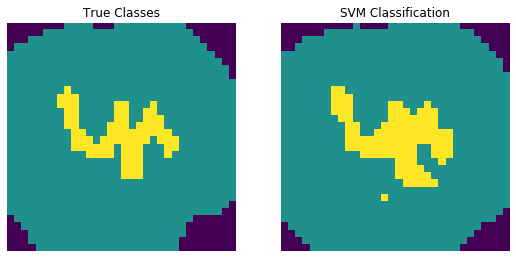

In [3]:
from sklearn import svm
from sklearn.metrics import classification_report

train = mypackage.StackTransform(X_train, Y_train)
test = mypackage.StackTransform(X_test, Y_test)

svc_classifier = svm.SVC(C=1, kernel='rbf', decision_function_shape='ovr')
print("Start training")
timer.start()
svc_classifier.fit(train.X_stack(), train.Y_stack().ravel())
timer.stop()

# save the model to disk
filename = 'latest_svm_model.sav'
joblib.dump(svc_classifier, filename)

# # load the model from disk
# svc_classifier = joblib.load(filename)
Y_hat = svc_classifier.predict(train.X_stack())
classification = classification_report(train.Y_stack(), Y_hat) # .flatten()
print("Training data prediction")
print(classification)
print("Test data prediction")
timer.start()
Y_hat = svc_classifier.predict(test.X_stack())
timer.stop()
classification = classification_report(test.Y_stack(), Y_hat) # .flatten()
print(classification)

Y_hat = test.Unstack(Y_hat, k=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.title("True Classes")
plt.imshow(np.squeeze(Y_test[0]))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("SVM Classification")
plt.imshow(np.squeeze(Y_hat[0]))
plt.axis('off');

# Testing Logistic Regression

Start training
Elapsed time: 36.4686 seconds
Training data prediction
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1108
         1.0       1.00      1.00      1.00      3719
         2.0       1.00      1.00      1.00       293

    accuracy                           1.00      5120
   macro avg       1.00      1.00      1.00      5120
weighted avg       1.00      1.00      1.00      5120

Test data prediction
Elapsed time: 0.0044 seconds
              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90       734
         1.0       0.93      0.98      0.96      3855
         2.0       0.86      0.61      0.71       531

    accuracy                           0.93      5120
   macro avg       0.91      0.82      0.86      5120
weighted avg       0.93      0.93      0.92      5120



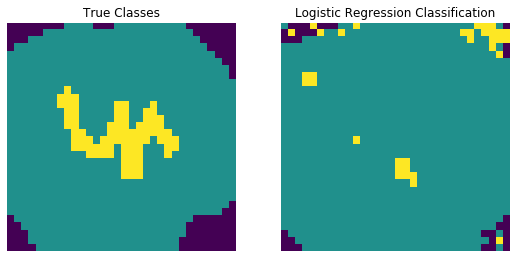

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

train = mypackage.StackTransform(X_train[:5], Y_train[:5])
test = mypackage.StackTransform(X_test[:5], Y_test[:5])

logreg = LogisticRegression(C=1e5, max_iter=50000)
print("Start training")
timer.start()
logreg.fit(train.X_stack(), train.Y_stack().ravel())
timer.stop()

# save the model to disk
filename = 'latest_LogisticReg_model.sav'
joblib.dump(logreg, filename)

# # load the model from disk
# logreg = joblib.load(filename)
Y_hat = logreg.predict(train.X_stack())
classification = classification_report(train.Y_stack(), Y_hat) # .flatten()
print("Training data prediction")
print(classification)
print("Test data prediction")
timer.start()
Y_hat = logreg.predict(test.X_stack())
timer.stop()
classification = classification_report(test.Y_stack(), Y_hat) # .flatten()
print(classification)

Y_hat = test.Unstack(Y_hat, k=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.title("True Classes")
plt.imshow(np.squeeze(Y_test[0]))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Logistic Regression Classification")
plt.imshow(np.squeeze(Y_hat[0]))
plt.axis('off');

### Test MyUNet on the same data

Start training
X_input (328, 32, 32, 208, 1), Y_input (328, 32, 32, 3)
Train on 295 samples, validate on 33 samples
Epoch 1/60
290/295 [============================>.] - ETA: 0s - loss: 0.6947 - accuracy: 0.8189
Epoch 00001: val_loss improved from inf to 0.81367, saving model to best-model.hdf5
295/295 [==============================] - 17s 59ms/sample - loss: 0.6912 - accuracy: 0.8204 - val_loss: 0.8137 - val_accuracy: 0.8721
Epoch 2/60
290/295 [============================>.] - ETA: 0s - loss: 0.4275 - accuracy: 0.9093
Epoch 00002: val_loss improved from 0.81367 to 0.72828, saving model to best-model.hdf5
295/295 [==============================] - 15s 52ms/sample - loss: 0.4254 - accuracy: 0.9096 - val_loss: 0.7283 - val_accuracy: 0.7931
Epoch 3/60
290/295 [============================>.] - ETA: 0s - loss: 0.3045 - accuracy: 0.9275
Epoch 00003: val_loss improved from 0.72828 to 0.57616, saving model to best-model.hdf5
295/295 [==============================] - 15s 52ms/sample - loss:

Epoch 28/60
290/295 [============================>.] - ETA: 0s - loss: 0.0809 - accuracy: 0.9704
Epoch 00028: val_loss did not improve from 0.11162
295/295 [==============================] - 15s 52ms/sample - loss: 0.0807 - accuracy: 0.9705 - val_loss: 0.1278 - val_accuracy: 0.9565
Epoch 29/60
290/295 [============================>.] - ETA: 0s - loss: 0.0699 - accuracy: 0.9742
Epoch 00029: val_loss improved from 0.11162 to 0.10863, saving model to best-model.hdf5
295/295 [==============================] - 15s 52ms/sample - loss: 0.0702 - accuracy: 0.9741 - val_loss: 0.1086 - val_accuracy: 0.9605
Epoch 30/60
290/295 [============================>.] - ETA: 0s - loss: 0.0699 - accuracy: 0.9742
Epoch 00030: val_loss did not improve from 0.10863
295/295 [==============================] - 15s 52ms/sample - loss: 0.0697 - accuracy: 0.9742 - val_loss: 0.1599 - val_accuracy: 0.9487
Epoch 31/60
290/295 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9724
Epoch 00031: val_

Epoch 57/60
290/295 [============================>.] - ETA: 0s - loss: 0.0524 - accuracy: 0.9805
Epoch 00057: val_loss did not improve from 0.10863
295/295 [==============================] - 15s 52ms/sample - loss: 0.0522 - accuracy: 0.9805 - val_loss: 0.1313 - val_accuracy: 0.9576
Epoch 58/60
290/295 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9835
Epoch 00058: val_loss did not improve from 0.10863
295/295 [==============================] - 15s 52ms/sample - loss: 0.0432 - accuracy: 0.9835 - val_loss: 0.1250 - val_accuracy: 0.9593
Epoch 59/60
290/295 [============================>.] - ETA: 0s - loss: 0.0423 - accuracy: 0.9838
Epoch 00059: val_loss did not improve from 0.10863
295/295 [==============================] - 15s 52ms/sample - loss: 0.0422 - accuracy: 0.9838 - val_loss: 0.1318 - val_accuracy: 0.9567
Epoch 60/60
290/295 [============================>.] - ETA: 0s - loss: 0.0424 - accuracy: 0.9838
Epoch 00060: val_loss did not improve from 0.10863
295

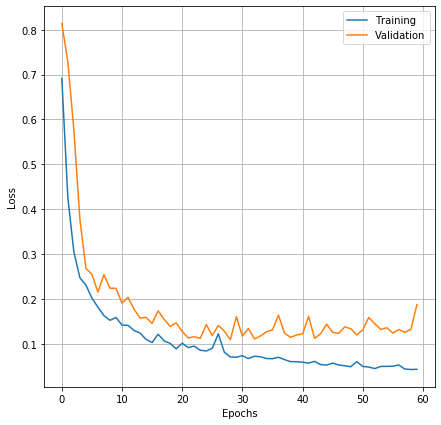

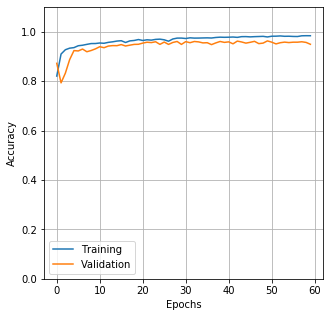

Predicting for train data
Elapsed time: 4.3353 seconds
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     92600
           1       0.98      0.99      0.99    211543
           2       0.94      0.92      0.93     31729

    accuracy                           0.98    335872
   macro avg       0.97      0.96      0.97    335872
weighted avg       0.98      0.98      0.98    335872



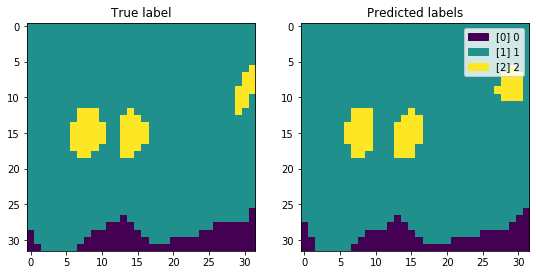

Predicting for test data
Elapsed time: 1.7586 seconds
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     32410
           1       0.97      0.98      0.98     98030
           2       0.90      0.85      0.87     13944

    accuracy                           0.97    144384
   macro avg       0.95      0.93      0.94    144384
weighted avg       0.96      0.97      0.96    144384



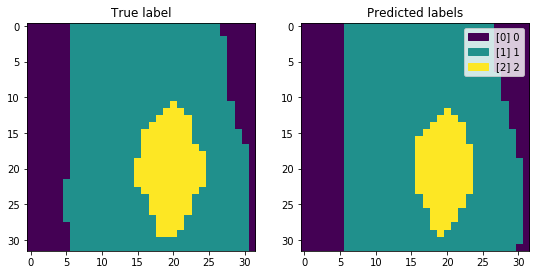

Elapsed time: 2.2145 seconds


In [5]:
unet = mypackage.MyUnet.UNet(X_train, Y_train)
print("Start training")
timer.start()
unet.train(batch_size=5, epochs=60, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min')
timer.stop()

# unet.summary()
unet.plot_training_results()
print("Predicting for train data")
unet.predict(X_train, Y_labels=Y_train)
print("Predicting for test data")
timer.start()
unet.predict(X_test, Y_labels=Y_test);
timer.stop()


Elapsed time: 1.7857 seconds
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     32410
           1       0.97      0.98      0.98     98030
           2       0.90      0.85      0.87     13944

    accuracy                           0.97    144384
   macro avg       0.95      0.93      0.94    144384
weighted avg       0.96      0.97      0.96    144384



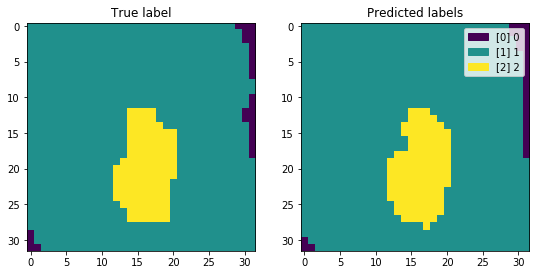

In [22]:
unet.predict(X_test, Y_labels=Y_test);

In [8]:
# TODO: Check if the clear plastic up-top is close to being classified correctly
dataset_folder = 'data/tomra_weak_labeling'
file_list = ['20200213_121142_new_FM_fillet_sample_C_26']

X_26, Y_26 = mypackage.Dataset.load_files(file_list, dataset_folder, with_labels=True)
X_26, _, scaler = mypackage.Dataset.scale(X_26, None, scaler=scaler)

Elapsed time: 0.0326 seconds
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       379
           1       0.97      0.99      0.98       583
           2       0.93      0.89      0.91        62

    accuracy                           0.98      1024
   macro avg       0.97      0.95      0.96      1024
weighted avg       0.98      0.98      0.98      1024



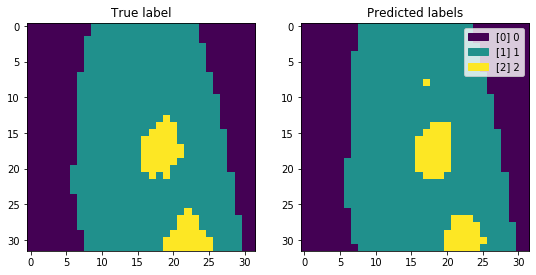

In [21]:
unet.predict(X_26[0:1, 34:-34, 34:-34, :], Y_labels=Y_26[0:1, 34:-34, 34:-34, :]);

In [2]:
# https://stackoverflow.com/questions/38009682/how-to-tell-if-tensorflow-is-using-gpu-acceleration-from-inside-python-shell
import tensorflow as tf
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
print("The following list should not be empty")
print(tf.test.gpu_device_name())
print("The following should contain stuff, and then be True, True")
print(tf.config.experimental.list_physical_devices('GPU'), tf.test.is_built_with_cuda(), tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6433163898939636845
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14030495234171197251
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12541629888044493427
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3135766528
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2678163865343470105
physical_device_desc: "device: 0, name: Quadro M2000M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]
The following list should not be empty
/device:GPU:0
The following should contain stuff, and then be True, True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] True True


# Test Partial Least Squares - Discriminant Analysis (PLS-DA)

In [12]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import classification_report

train = mypackage.StackTransform(X_train[:5], Y_train[:5])
test = mypackage.StackTransform(X_test[:5], Y_test[:5])

plsreg = PLSRegression(n_components=3, scale=False)
print("Start training")

# Train on this:
a = train.Y_stack().ravel().copy()
a[a == 1] = 0
np.unique(a)

timer.start()
plsreg.fit(train.X_stack(), train.Y_stack().ravel())
timer.stop()

# save the model to disk
filename = 'latest_PLS-Reg_model.sav'
joblib.dump(plsreg, filename)

# # load the model from disk
# logreg = joblib.load(filename)
Y_hat = plsreg.predict(train.X_stack())

# Then run OAO classifiers
print(np.unique(a[Y_hat[:, 0] <= 1], return_counts=True))

Start training
Elapsed time: 0.0189 seconds
